In [1]:
import tomotopy as tp
import numpy as np
import pandas as pd
import re
import os
import time
import itertools
import konlpy
from kiwipiepy import Kiwi
from hanspell import spell_checker
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyLDAvis


In [2]:
df=pd.read_csv('activity.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2537 non-null   object 
 1   review        2537 non-null   object 
 2   score         2537 non-null   object 
 3   real_date     2537 non-null   object 
 4   year          2537 non-null   float64
 5   month         2537 non-null   float64
 6   type          2272 non-null   object 
 7   dataset       2500 non-null   object 
dtypes: float64(2), object(6)
memory usage: 158.7+ KB


C:\Users\jenny\AppData\Local\Temp/ipykernel_17200/2320953125.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df=pd.read_csv('activity.csv',encoding='utf-8-sig',header=0, dtype={'score':np.str})


In [3]:
df['type'].unique()

array([' 가족', ' 비지니스', ' 개인', nan, ' 커플', ' 친구'], dtype=object)

In [4]:
for i in range(len(df)):
    if df.iloc[i,6] in [' 친구',' 가족',' 커플']:
        df.iloc[i,6] = 'no_solo'
    elif df.iloc[i,6] in [' 비지니스', np.NaN]:
        df.iloc[i,6] = np.NaN
    elif df.iloc[i,6] in [' 개인']:
        df.iloc[i,6]='solo'

In [5]:
df['type'].unique()

array(['no_solo', nan, 'solo'], dtype=object)

In [6]:
df.dropna(subset=['type'], how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2149 entries, 0 to 2535
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  2149 non-null   object 
 1   review        2149 non-null   object 
 2   score         2149 non-null   object 
 3   real_date     2149 non-null   object 
 4   year          2149 non-null   float64
 5   month         2149 non-null   float64
 6   type          2149 non-null   object 
 7   dataset       2114 non-null   object 
dtypes: float64(2), object(6)
memory usage: 151.1+ KB


In [7]:
#솔로/비솔로 데이터 구분
#비솔로
condition = (df.type=='no_solo')
df2=df.loc[condition]

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1725 entries, 0 to 2534
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  1725 non-null   object 
 1   review        1725 non-null   object 
 2   score         1725 non-null   object 
 3   real_date     1725 non-null   object 
 4   year          1725 non-null   float64
 5   month         1725 non-null   float64
 6   type          1725 non-null   object 
 7   dataset       1704 non-null   object 
dtypes: float64(2), object(6)
memory usage: 121.3+ KB


In [9]:
df2.dropna(subset=['dataset'], how='any', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704 entries, 0 to 2534
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   review_title  1704 non-null   object 
 1   review        1704 non-null   object 
 2   score         1704 non-null   object 
 3   real_date     1704 non-null   object 
 4   year          1704 non-null   float64
 5   month         1704 non-null   float64
 6   type          1704 non-null   object 
 7   dataset       1704 non-null   object 
dtypes: float64(2), object(6)
memory usage: 119.8+ KB


C:\Users\jenny\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
#응집도 계산 전 사용할 토크나이저 함수 정의

import konlpy
stop_list=['우리','함께','있습니다']
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)
    
    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)
    
    words = []
    for word, pos in Okt_morphs:
        if not pos == 'Josa' and not pos =='Punctuation' and not pos =='Foreign' and len(word) > 1 and word not in stop_list :
            words.append(word)
    ## word를 이어붙인 string 형태가 아닌 word의 list를 return해주는 게 sklearn lda 준비 과정과의 차이
            
    return words

In [11]:
#솔로 데이터 토큰화
tokenized_list_no = []
a=df2['dataset'].values
for text in range(len(a)):
    tokenized_list_no.append(tokenize_korean_text(a[text]))

In [12]:
#솔로
model = tp.DMRModel(k=20, alpha=0.1, eta=0.01, min_cf=1,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no


for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass
        
               
model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 

Total docs: 1704
Total words: 48809
Vocab size: 7336


In [13]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1704 docs, 48809 words
| Total Vocabs: 7339, Used Vocabs: 7336
| Entropy of words: 7.28709
| Entropy of term-weighted words: 8.03921
| Removed Vocabs: 박물관 있는 한국
| Metadata of docs and its distribution
|  5: 1047
|  3: 129
|  4: 500
|  1: 11
|  2: 17
|
<Training Info>
| Iterations: 0, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -10.41602
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 1 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 20 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal d

==== Coherence : c ====
Average: 0.4341513275611214 
Per Topic: [0.45522864125669005, 0.4260441519320011, 0.47097086161375046, 0.4738592028617859, 0.4903569996356964, 0.4029907710850239, 0.334386826865375, 0.40006461143493655, 0.42414284870028496, 0.36293424293398857, 0.41689282804727557, 0.43736319839954374, 0.46875177323818207, 0.4596735820174217, 0.4411409226246178, 0.4625438414514065, 0.4081815416458994, 0.46038377583026885, 0.4801227912306786, 0.4069931384176016]


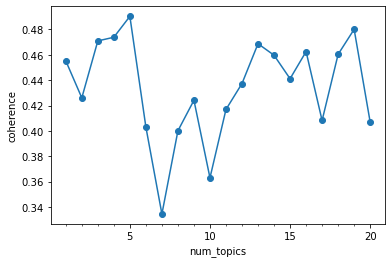

In [14]:
# calculate coherence using preset
ax=plt.axes()
coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
print('==== Coherence : c ====')
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
x=range(1,21,1)
plt.plot(x, coherence_per_topic,marker='o')
plt.xlabel("num_topics")
plt.ylabel("coherence")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()
print()

위 결과에서 14개일 때 가장 높은 응집도를 보였기 때문에 토픽을 14개로 설정하였다.

In [15]:
#토픽수 정하고 솔로 분석
model = tp.DMRModel(k=4, alpha=0.1, eta=0.01, min_cf=1,rm_top=3,tw=tp.TermWeight.IDF)

key=df2['score'].values
value=tokenized_list_no

for pairs in zip(key, value):
    try :
        model.add_doc(pairs[1],metadata=pairs[0]) # tokenize함수를 이용해 전처리한 결과를 add_doc에 넣습니다.
    except RuntimeError :
        pass

model.train(0)
print('Total docs:', len(model.docs))
print('Total words:', model.num_words)
print('Vocab size:', model.num_vocabs)
 
 
 
for i in range(200):
    model.train(1)
    
for i in range(model.k):
    res = model.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Total docs: 1704
Total words: 48809
Vocab size: 7336
Topic #0	전쟁, 역사, 많은, 무료, 시간, 좋은, 매우, 정보, 기념관, 모든
Topic #1	전시, 관람, 아이, 좋아요, 있어서, 중앙, 어린이, 미술관, 좋습니다, 우리나라
Topic #2	사진, 재미있는, 경험, 친구, 재미, 시간, 장소, 얼음, 그것, 공연
Topic #3	전쟁, 나라, 너무, 그녀, 않고, 가게, 사람, 주는, 아이, 하고


In [16]:
model.summary()

<Basic Info>
| DMRModel (current version: 0.12.2)
| 1704 docs, 48809 words
| Total Vocabs: 7339, Used Vocabs: 7336
| Entropy of words: 7.28709
| Entropy of term-weighted words: 8.03921
| Removed Vocabs: 박물관 있는 한국
| Metadata of docs and its distribution
|  5: 1047
|  3: 129
|  4: 500
|  1: 11
|  2: 17
|
<Training Info>
| Iterations: 200, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.00884
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 1 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 4 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (an initial value of exponential of mean of normal distribution for `lambdas`, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic - word)
| sigma: 1.0 (standard deviation of normal d

In [17]:
#솔로 감성점수 계산
print('Topic distributions by score, solo')

df4=pd.DataFrame()
score_labels=['1','2','3','4','5']

for i in score_labels:
    df4[i+'score']=model.get_topic_prior(i)
df4['total']=df4.sum(axis=1)

total_sum=df4['total'].values
gamsung_sum=0
gamsung_list=[]

for i in range(model.k):
    a=df4.iloc[i,:-1].values
    gamsung_sum=(a[0]*1+a[1]*2+a[2]*3+a[3]*4+a[4]*5)/total_sum[i]
    gamsung_list.append(gamsung_sum)
    
df4['re_score']=gamsung_list
df4.head(20)

Topic distributions by score, solo


,1score,2score,3score,4score,5score,total,re_score
0,0.084689,0.050718,0.040822,0.516802,1.045229,1.738260,4.373305
1,0.194029,0.039170,0.024250,0.071600,0.043930,0.372979,2.282083
2,0.054324,0.014492,0.088347,0.323696,0.414849,0.895709,4.150212
3,0.174587,0.041483,0.050866,0.071109,0.162616,0.500661,3.011355


In [18]:
#각 토픽 별 상위 10개 단어 추출
word_list=[]
for i in range(model.k):
    a=model.get_topic_words(i, top_n=10)
    word_list.append([x[0] for x in a])

df4['word_list']=word_list
df4.head(15)

,1score,2score,3score,4score,5score,total,re_score,word_list
0,0.084689,0.050718,0.040822,0.516802,1.045229,1.738260,4.373305,"[전쟁, 역사, 많은, 무료, 시간, 좋은, 매우, 정보, 기념관, 모든]"
1,0.194029,0.039170,0.024250,0.071600,0.043930,0.372979,2.282083,"[전시, 관람, 아이, 좋아요, 있어서, 중앙, 어린이, 미술관, 좋습니다, 우리나라]"
2,0.054324,0.014492,0.088347,0.323696,0.414849,0.895709,4.150212,"[사진, 재미있는, 경험, 친구, 재미, 시간, 장소, 얼음, 그것, 공연]"
3,0.174587,0.041483,0.050866,0.071109,0.162616,0.500661,3.011355,"[전쟁, 나라, 너무, 그녀, 않고, 가게, 사람, 주는, 아이, 하고]"


In [19]:
 # extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=5, min_df=5, max_len=5, max_cand=10000, normalized=True)
cands = extractor.extract(model)

labeler = tp.label.FoRelevance(model, cands, min_df=5, smoothing=1e-2, mu=0.25)
for k in range(model.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in model.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 한국, 있는, 모든, 박물관, 시간
전쟁	0.009628325700759888
역사	0.007902947254478931
많은	0.006869974546134472
무료	0.006236988119781017
시간	0.005721142049878836
좋은	0.005530619528144598
매우	0.005296760704368353
정보	0.00526299187913537
기념관	0.005223428830504417
모든	0.005203502718359232

== Topic #1 ==
Labels: 관람, 대한민국 대표, 연결 되어, 가시, 주차
전시	0.00902759563177824
관람	0.007556361611932516
아이	0.007271222770214081
좋아요	0.006482959724962711
있어서	0.006074205972254276
중앙	0.005828101187944412
어린이	0.00576761644333601
미술관	0.0053528472781181335
좋습니다	0.00535197090357542
우리나라	0.0050300429575145245

== Topic #2 ==
Labels: 사진, Ice, 얼음, 로커, 카메라
사진	0.01421237550675869
재미있는	0.007528217975050211
경험	0.006438449025154114
친구	0.006344837136566639
재미	0.005843170452862978
시간	0.005691996775567532
장소	0.00568210007622838
얼음	0.005201168358325958
그것	0.004959261044859886
공연	0.004796575754880905

== Topic #3 ==
Labels: 희망, 한국 이해, 나라 위해, 비극, 있는 체험
전쟁	0.005524120293557644
나라	0.005338463466614485
너무	0.004888693802058697
그녀	0.00458

In [20]:
#빈도 구하기 전
df5=pd.DataFrame()
df5['docs']=tokenized_list_no
df5['score']=df2['score'].values
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docs    1704 non-null   object
 1   score   1704 non-null   object
dtypes: object(2)
memory usage: 26.8+ KB


In [21]:
#빈도 구하기

topic_num=[]
temp1=[] #토픽번호
temp2=[] #분포율
for i in range(len(model.docs)):
    a=model.docs[i].get_topics()
    temp1.append([x[0] for x in a])
    temp2.append([x[1] for x in a])
for i in range(len(temp1)):
    if temp2[i][0] >= 0.5:
        topic_num.append(temp1[i][0])
    else :
        topic_num.append(np.NaN)
df5['topic_num']=topic_num
df5[df5['topic_num'].isnull()]

,docs,score,topic_num
4,"[매우, 즐거운, 온라인, 예약, 할인, 가격, 사전, 예약, 받지, 않고, 카운터...",4,NaN
6,"[재미있는, 유능한, 공연, 배우, 재미있는, 걸어주었다, 한국말, 하지, 너무, ...",3,NaN
7,"[모든, 커버, 주는, 처음, 철저하게, 재미있었습니다, 기대, 도구, 사용, 하여...",5,NaN
8,"[즐겁고, 유쾌한, 서울, 도착, 위해, 예약, 저희, 명동, 있는, 머물, 선택,...",5,NaN
10,"[기막히게, 멋져요, 재미있는, 구걸, 너무, 재밌었고, 그냥, 유쾌하고, 배우, ...",5,NaN
...,...,...,...
1668,"[재미있지만, 비싸다, 무슨, 재미, 휴대, 전화, 완전, 충전, 상태, 확인, 하...",3,NaN
1688,"[그럴, 가치, 없어, 사기, 비트, 특별한, 없지만, 실제, 약하다, 귀찮은, 스...",1,NaN
1693,"[아이, 정말, 좋아했어요, 아이, 먼저, 가자고, 제안, 해서, 봤는데, 아빠, ...",5,NaN
1694,"[방문, 후기, 너무, 너무, 재미있었고, 오고, 싶어요, 그리고, 컵홀더, 예쁜,...",5,NaN


In [22]:
df6=df5.groupby(['topic_num','score'])['docs']
print(df6.size().reset_index(name='counts'))

    topic_num score  counts
0         0.0     1       1
1         0.0     2       2
2         0.0     3      36
3         0.0     4     200
4         0.0     5     468
5         1.0     1       1
6         1.0     2       4
7         1.0     3      28
8         1.0     4     119
9         1.0     5     174
10        2.0     1       4
11        2.0     2       6
12        2.0     3      31
13        2.0     4      96
14        2.0     5     223
15        3.0     2       1
16        3.0     3       5
17        3.0     4      11
18        3.0     5      20
